In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rasterio as rio

from pathlib import Path
from osgeo import gdal
from pyproj import Proj, Transformer
from rasterio import plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.interpolate import RegularGridInterpolator

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import caesarpy as cp

In [2]:
path_to_tif = Path('./tet/')

In [3]:
dem_asc = path_to_tif/'dem_200m_preproc.asc'
nx, ny, geotransform, dem = cp.asc2numpy(str(dem_asc))

In [4]:
ul = (geotransform[0], geotransform[3])
lr = (geotransform[0] + nx * geotransform[1], geotransform[3] + ny * geotransform[5])
ll = (geotransform[0], geotransform[3] + ny * geotransform[5])

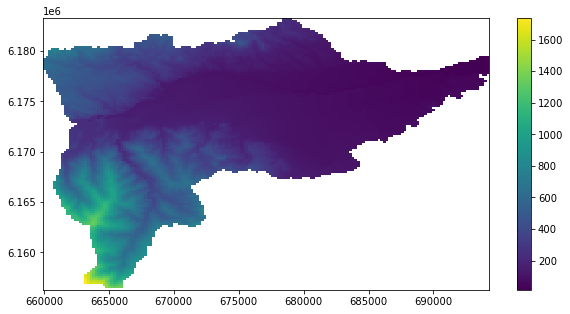

In [5]:
dx = geotransform[1]

x = np.linspace(ll[0], ll[0] + dx * (nx -1), nx)
y = np.linspace(ll[1] + dx * (ny -1), ll[1], ny)
X,Y = np.meshgrid(x, y, indexing='xy')

plt.figure(figsize=[10,5])
plt.subplot(111)
plt.pcolormesh(X, Y, dem)
plt.colorbar()
plt.show()

In [6]:
pr = Proj('+proj=igh +datum=WGS84 +no_defs +towgs84=0,0,0', preserve_units=False)

In [7]:
transproj = Transformer.from_crs('EPSG:2154', '+proj=igh +datum=WGS84 +no_defs +towgs84=0,0,0', always_xy=True)

In [8]:
x = np.zeros((2,))
y = np.zeros((2,))
for i, pt in enumerate(transproj.itransform([ul, lr])):
    x[i], y[i] = pt
    print('{:.3f} {:.3f}'.format(*pt))

1066108.535 4757498.186
1095387.648 4730891.452


In [9]:
lr[0] - ul[0]

34400.0

In [10]:
ul[1] - lr[1]

27000.0

In [11]:
x[1] - x[0]

29279.113212971482

## Get the SoilGrids tile(s) for the same region

Will use the SoilGrids model output to estimate the grain size proportions. See these examples: https://git.wur.nl/isric/soilgrids/soilgrids.notebooks/-/tree/master. Start with the `silt.map` layer:

In [12]:
from owslib.wcs import WebCoverageService
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/silt.map',
                         version='2.0.1')

I cannot get any map projection to work with the API, so I will use their projection to download GeoTiffs and then QGis can do its magic and get them back into some useful format that I understand. For the SoilGrids projection see: https://www.isric.org/explore/soilgrids/faq-soilgrids#How_can_I_use_the_Homolosine_projection

Look at SoilGrid silt layers

In [13]:
print(list(wcs.contents))

['silt_0-5cm_Q0.05', 'silt_0-5cm_Q0.5', 'silt_0-5cm_Q0.95', 'silt_0-5cm_mean', 'silt_0-5cm_uncertainty', 'silt_5-15cm_Q0.05', 'silt_5-15cm_Q0.5', 'silt_5-15cm_Q0.95', 'silt_5-15cm_mean', 'silt_5-15cm_uncertainty', 'silt_15-30cm_Q0.05', 'silt_15-30cm_Q0.5', 'silt_15-30cm_Q0.95', 'silt_15-30cm_mean', 'silt_15-30cm_uncertainty', 'silt_30-60cm_Q0.5', 'silt_30-60cm_Q0.05', 'silt_30-60cm_Q0.95', 'silt_30-60cm_mean', 'silt_30-60cm_uncertainty', 'silt_60-100cm_Q0.05', 'silt_60-100cm_Q0.5', 'silt_60-100cm_Q0.95', 'silt_60-100cm_mean', 'silt_60-100cm_uncertainty', 'silt_100-200cm_Q0.5', 'silt_100-200cm_Q0.05', 'silt_100-200cm_Q0.95', 'silt_100-200cm_mean', 'silt_100-200cm_uncertainty']


In [14]:
cov_id = 'silt_0-5cm_mean'
silt_0_5 = wcs.contents[cov_id]
silt_0_5.supportedFormats

['image/tiff',
 'image/png',
 'image/jpeg',
 'image/png; mode=8bit',
 'image/vnd.jpeg-png',
 'image/vnd.jpeg-png8']

In [15]:
subsets = [('X', int(np.round(x[0] - 10000, -2)), int(np.round(x[1] + 10000, -2))),
           ('Y', int(np.round(y[1] - 10000, -2)), int(np.round(y[0] + 10000, -2)))]
print(subsets)

[('X', 1056100, 1105400), ('Y', 4720900, 4767500)]


In [16]:
response = wcs.getCoverage(
    identifier=[cov_id], 
    crs='http://www.opengis.net/def/crs/EPSG/0/152160',
    subsets=subsets, 
    resx=250, resy=250, 
    format=silt_0_5.supportedFormats[0])

In [17]:
with open('./tet/tet_silt_0-5cm_mean.tif', 'wb') as file:
    file.write(response.read())

In [18]:
silt05 = rio.open('./tet/tet_silt_0-5cm_mean.tif', driver="GTiff")

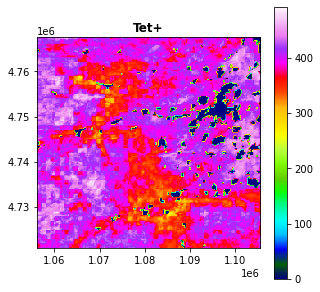

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
image = plot.show(silt05, title='Tet+', cmap='gist_ncar', ax=ax)
im = image.get_images()[0]
fig.colorbar(im, ax=ax)

In [20]:
silt05.crs

CRS.from_wkt('PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [21]:
dstCrs = {'init': 'EPSG:2154'}

In [22]:
transform, width, height = calculate_default_transform(silt05.crs, dstCrs, silt05.width, silt05.height, *silt05.bounds)

In [23]:
print(silt05.transform)

| 250.25, 0.00, 1056100.00|
| 0.00,-250.54, 4767500.00|
| 0.00, 0.00, 1.00|


In [24]:
print(transform)

| 277.01, 0.00, 648089.27|
| 0.00,-277.01, 6193585.09|
| 0.00, 0.00, 1.00|


In [25]:
kwargs = silt05.meta.copy()
kwargs.update({
        'crs': dstCrs,
        'transform': transform,
        'width': width,
        'height': height
    })

In [26]:
dstRst = rio.open('./tet/tet_silt_0-5cm_mean_Lambert.tif', 'w', **kwargs)

In [27]:
for i in range(1, silt05.count + 1):
    reproject(
        source=rio.band(silt05, i),
        destination=rio.band(dstRst, i),
        #src_transform=srcRst.transform,
        src_crs=silt05.crs,
        #dst_transform=transform,
        dst_crs=dstCrs,
        resampling=Resampling.nearest)

In [28]:
dstRst.close()

In [29]:
silt05 = rio.open('./tet/tet_silt_0-5cm_mean_Lambert.tif', driver="GTiff")

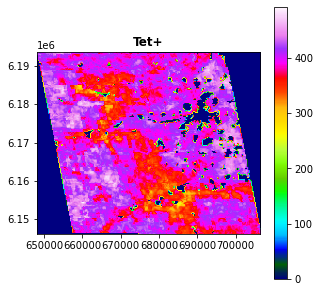

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
image = plot.show(silt05, title='Tet+', cmap='gist_ncar', ax=ax)
im = image.get_images()[0]
fig.colorbar(im, ax=ax)

In [64]:
_Z = np.flipud(silt05.read(1).astype(float))  # so that y is ascending

In [65]:
ny, nx = _Z.shape

In [66]:
_Z.shape

(171, 210)

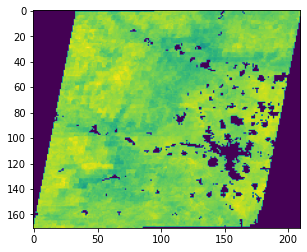

In [67]:
plt.figure()
plt.imshow(_Z)

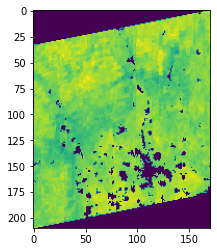

In [68]:
plt.figure()
plt.imshow(_Z.T)

In [69]:
dx = silt05.transform[0]
dy = silt05.transform[4]
ul = (silt05.transform[2], silt05.transform[5])

x = np.linspace(ul[0], ul[0] + dx * (nx -1), nx)
y = np.linspace(ul[1] + dy * (ny -1), ul[1], ny)  # so that y is ascending
_X, _Y = np.meshgrid(x, y, indexing='ij')

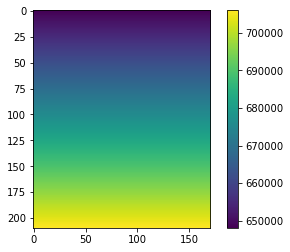

In [70]:
plt.figure()
plt.imshow(_X)
plt.colorbar()

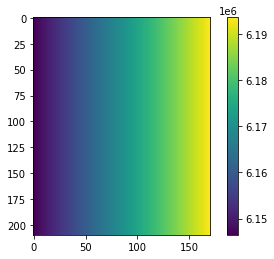

In [71]:
plt.figure()
plt.imshow(_Y)
plt.colorbar()

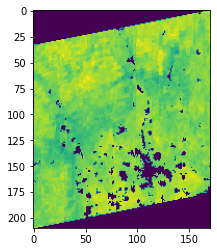

In [72]:
plt.figure()
plt.imshow(_Z.T)

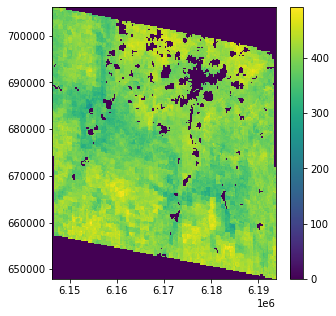

In [73]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.pcolormesh(_Y, _X, _Z.T)
plt.colorbar()

In [74]:
interp = RegularGridInterpolator((y, x), _Z)

In [75]:
Z = interp((Y, X))

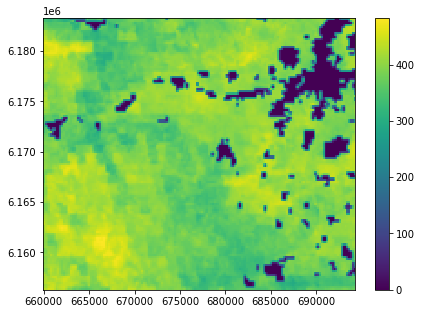

In [78]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(X, Y, Z)
plt.colorbar()

In [79]:
Z[np.isnan(dem)] = np.nan

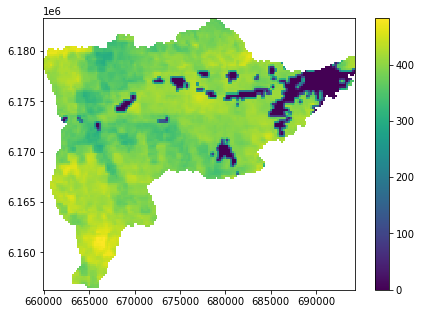

In [80]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(X, Y, Z)
plt.colorbar()

In [82]:
np.nanmedian(Z)

392.03684240404414

In [83]:
np.nanmean(Z)

361.9088525766689

In [ ]:
sizes = ['0-5cm', '5-15cm', '15-30cm']
for size in sizes:

    cov_id = f'silt_{size}_mean'
    response = wcs.getCoverage(
        identifier=[cov_id], 
        crs='http://www.opengis.net/def/crs/EPSG/0/152160',
        subsets=subsets, 
        resx=250, resy=250, 
        format=silt_0_5.supportedFormats[0])
    with open(f'./tet/tet_silt_{size}_mean.tif', 'wb') as file:
        file.write(response.read())

In [ ]:
from owslib.wcs import WebCoverageService
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/sand.map',
                         version='2.0.1')

In [ ]:
print(list(wcs.contents))

In [ ]:
sizes = ['0-5cm', '5-15cm', '15-30cm']
for size in sizes:

    cov_id = f'sand_{size}_mean'
    response = wcs.getCoverage(
        identifier=[cov_id], 
        crs='http://www.opengis.net/def/crs/EPSG/0/152160',
        subsets=subsets, 
        resx=250, resy=250, 
        format=silt_0_5.supportedFormats[0])
    with open(f'./tet/tet_sand_{size}_mean.tif', 'wb') as file:
        file.write(response.read())

In [ ]:
from owslib.wcs import WebCoverageService
wcs = WebCoverageService('http://maps.isric.org/mapserv?map=/map/cfvo.map',
                         version='2.0.1')

In [ ]:
print(list(wcs.contents))

In [ ]:
sizes = ['0-5cm', '5-15cm', '15-30cm']
for size in sizes:

    cov_id = f'cfvo_{size}_mean'
    response = wcs.getCoverage(
        identifier=[cov_id], 
        crs='http://www.opengis.net/def/crs/EPSG/0/152160',
        subsets=subsets, 
        resx=250, resy=250, 
        format=silt_0_5.supportedFormats[0])
    with open(f'./tet/tet_cfvo_{size}_mean.tif', 'wb') as file:
        file.write(response.read())